In [6]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import dtale

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
import pickle


In [7]:
df_leagues = pd.read_csv('../data/csv/Leagues.csv', index_col=0)

df_leagues.drop(['date', 'matchweek', 'home_team_id', 'away_team_id', 'home_team', 'away_team', 'home_manager', 'away_manager', 'home_xg', 'away_xg', 'home_formation', 'away_formation'], axis=1, inplace=True)
print(f'Nb NaN: {df_leagues.isna().sum().sum()}')

df_leagues['home_team_form'] = df_leagues['home_team_form'].fillna('')
df_leagues['home_team_home_form'] = df_leagues['home_team_home_form'].fillna('')
df_leagues['home_team_average_goals_form'] = df_leagues['home_team_average_goals_form'].fillna(0)
df_leagues['home_team_average_xg_form'] = df_leagues['home_team_average_xg_form'].fillna(0)
df_leagues['home_team_average_goals_form_against'] = df_leagues['home_team_average_goals_form_against'].fillna(0)
df_leagues['home_team_average_xg_form_against'] = df_leagues['home_team_average_xg_form_against'].fillna(0)
df_leagues['away_team_form'] = df_leagues['away_team_form'].fillna('')
df_leagues['away_team_away_form'] = df_leagues['away_team_away_form'].fillna('')
df_leagues['away_team_average_goals_form'] = df_leagues['home_team_average_goals_form'].fillna(0)
df_leagues['away_team_average_xg_form'] = df_leagues['home_team_average_xg_form'].fillna(0)
df_leagues['away_team_average_goals_form_against'] = df_leagues['home_team_average_goals_form_against'].fillna(0)
df_leagues['away_team_average_xg_form_against'] = df_leagues['home_team_average_xg_form_against'].fillna(0)


def calculate_points(results):
    points_map = {'W': 3, 'D': 1, 'L': 0}
    return sum(points_map[char] for char in results)

df_leagues['home_team_form'] = df_leagues['home_team_form'].apply(calculate_points)
df_leagues['away_team_form'] = df_leagues['away_team_form'].apply(calculate_points)

df_leagues['home_team_home_form'] = df_leagues['home_team_home_form'].apply(calculate_points)
df_leagues['away_team_away_form'] = df_leagues['away_team_away_form'].apply(calculate_points)

print(f'Nb NaN: {df_leagues.isna().sum().sum()}')

Nb NaN: 4752
Nb NaN: 0


In [8]:
df_leagues.describe()

,home_goals,away_goals,home_team_form,home_team_league_pos,home_team_points_diff,home_team_home_form,home_team_home_league_pos,home_team_home_points_diff,home_team_average_goals_form,home_team_average_xg_form,...,away_team_form,away_team_league_pos,away_team_points_diff,away_team_away_form,away_team_away_league_pos,away_team_away_points_diff,away_team_average_goals_form,away_team_average_xg_form,away_team_average_goals_form_against,away_team_average_xg_form_against
count,6561.000000,6561.000000,6561.000000,6561.000000,6561.000000,6561.000000,6561.000000,6561.000000,6561.000000,6561.000000,...,6561.000000,6561.000000,6561.000000,6561.000000,6561.000000,6561.000000,6561.000000,6561.000000,6561.000000,6561.000000
mean,1.525530,1.257125,6.099680,9.685719,-1.780674,4.022100,9.525072,-2.816339,1.418178,1.378814,...,6.252858,9.525225,-1.892852,3.117665,9.522786,0.097699,1.418178,1.378814,1.170248,1.117012
std,1.305241,1.168386,3.642165,5.836726,6.117191,2.683844,5.838765,5.752302,0.938568,0.674015,...,3.632709,5.817421,6.137371,2.511958,5.754039,5.125623,0.938568,0.674015,0.806803,0.564277
min,0.000000,0.000000,0.000000,1.000000,-39.000000,0.000000,1.000000,-25.000000,0.000000,0.000000,...,0.000000,1.000000,-37.000000,0.000000,1.000000,-20.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,3.000000,5.000000,-5.000000,2.000000,4.000000,-6.000000,0.666667,1.000000,...,4.000000,4.000000,-5.000000,1.000000,5.000000,-3.000000,0.666667,1.000000,0.666667,0.766667
50%,1.000000,1.000000,6.000000,9.000000,-1.000000,4.000000,9.000000,-2.000000,1.333333,1.333333,...,6.000000,9.000000,-1.000000,3.000000,9.000000,0.000000,1.333333,1.333333,1.000000,1.100000
75%,2.000000,2.000000,9.000000,15.000000,2.000000,6.000000,14.000000,1.000000,2.000000,1.766667,...,9.000000,14.000000,2.000000,5.000000,14.000000,3.000000,2.000000,1.766667,1.666667,1.466667
max,9.000000,8.000000,15.000000,24.000000,23.000000,9.000000,24.000000,17.000000,6.000000,4.600000,...,15.000000,24.000000,23.000000,9.000000,24.000000,15.000000,6.000000,4.600000,7.000000,4.000000


In [9]:
def get_train_test_split(df: pd.DataFrame, label_name:str = 'home_goals') -> (pd.DataFrame, pd.DataFrame, pd.Series, pd.Series):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

    y_train = df_train[f'{label_name}']
    y_test = df_test[f'{label_name}']

    del df_train[f'{label_name}']
    del df_test[f'{label_name}']
    
    return df_train, df_test, y_train, y_test


def get_X_train_test(df_train:pd.DataFrame, df_test:pd.DataFrame):
    dict_vectorizer = DictVectorizer(sparse=False)
    train_serie_dict = df_train.to_dict(orient='records')
    test_serie_dict = df_test.to_dict(orient='records')

    X_train = dict_vectorizer.fit_transform(train_serie_dict)
    X_test = dict_vectorizer.transform(test_serie_dict)
    
    return X_train, X_test, dict_vectorizer


### Predict Result

In [ ]:
df_leagues_scores = df_leagues.copy()
df_leagues_scores['result'] = [0 if x == 0 else 1 if x > 0 else 2 for x in df_leagues_scores['home_goals'] - df_leagues_scores['away_goals']]

df_train_score, df_test_score, y_train_score, y_test_score = get_train_test_split(df_leagues_scores, 'result')

del df_train_score['home_goals']
del df_train_score['away_goals']
del df_test_score['home_goals']
del df_test_score['away_goals']

X_train_score, X_test_score, score_dict_vectorizer = get_X_train_test(df_train_score, df_test_score)

df_result_accuracy = pd.DataFrame(columns=['max_depth', 'n_estimators', 'min_samples_split', 'accuracy_rf'])

class_counts = Counter(y_train_score)
print(class_counts)

doubt_weight = (class_counts[0] + class_counts[1] + class_counts[2]) / class_counts[0]
home_weight = (class_counts[0] + class_counts[1] + class_counts[2]) / class_counts[1]
away_weight = (class_counts[0] + class_counts[1] + class_counts[2]) / class_counts[2]

print(f'Home weight: {home_weight} | Doubt weight: {doubt_weight} | Away weight: {away_weight}')
class_weights = {0: doubt_weight, 1: home_weight, 2: away_weight}

for max_depth in tqdm(range(20,30,2)):
    print(f'Max depth: {max_depth}')
    for n_estimator in range(300, 500, 50):
        for min_samples_split in range(2,8,2):
            r_rf_model = RandomForestClassifier(max_depth=max_depth, 
                                                n_estimators=n_estimator,
                                                min_samples_split= min_samples_split,
                                                class_weight= class_weights,
                                                random_state=42)
            r_rf_model.fit(X_train_score, y_train_score)
            y_pred_result = r_rf_model.predict(X_test_score)

            tmp_score_rf = accuracy_score(y_test_score, y_pred_result)
            
            df_temp = pd.DataFrame([{'max_depth':max_depth,
                                        'n_estimators': n_estimator,
                                        'min_samples_split':min_samples_split,
                                        'accuracy_rf':tmp_score_rf}])
            
            if df_result_accuracy.empty:
                df_result_accuracy = df_temp
            else:
                df_result_accuracy = pd.concat([df_result_accuracy, df_temp], ignore_index = True)
    
df_result_accuracy = df_result_accuracy.sort_values('accuracy_rf', ascending=False)
df_result_accuracy.head(10)

Counter({1: 2237, 2: 1658, 0: 1353})
Home weight: 2.3459991059454626 | Doubt weight: 3.878787878787879 | Away weight: 3.1652593486127865


  0%|          | 0/5 [00:00<?, ?it/s]

Max depth: 20
Max depth: 22
Max depth: 24
Max depth: 26
Max depth: 28


,max_depth,n_estimators,min_samples_split,accuracy_rf
48,28,300,2,0.590251
51,28,350,2,0.588728
27,24,350,2,0.587966
30,24,400,2,0.587205
54,28,400,2,0.587205
24,24,300,2,0.585682
57,28,450,2,0.585682
6,20,400,2,0.584920
47,26,450,6,0.584920
44,26,400,6,0.584920


In [11]:
result_model = RandomForestClassifier(max_depth=26, 
                                      n_estimators=400,
                                      min_samples_split= 2,
                                      class_weight= class_weights,
                                      random_state=42)
result_model.fit(X_train_score, y_train_score)

features = list(score_dict_vectorizer.feature_names_)
importances = result_model.feature_importances_

feature_importances = pd.DataFrame({'feature': features, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
5,away_team_away_league_pos,0.109312
16,home_team_home_league_pos,0.098749
9,away_team_points_diff,0.051746
17,home_team_home_points_diff,0.051109
8,away_team_league_pos,0.050029
19,home_team_points_diff,0.049807
12,home_team_average_xg_form,0.049302
2,away_team_average_xg_form,0.048942
18,home_team_league_pos,0.048256
6,away_team_away_points_diff,0.047826


In [12]:
y_pred_score = result_model.predict(X_test_score)
accuracy_result = accuracy_score(y_test_score, y_pred_score)

print(f'Accuracy: {accuracy_result}')

Accuracy: 0.5818735719725818


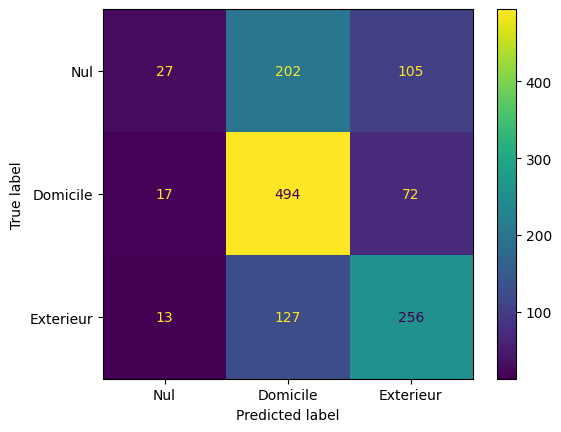

In [13]:
y_proba_result = result_model.predict_proba(X_test_score)

#for i in np.linspace(0.3,0.4, 20):
y_pred_score = [1 if x[1] > 0.33 else 2 if x[2] > 0.33 else 0 for x in y_proba_result]

accuracy_result = accuracy_score(y_test_score, y_pred_score)
#print(f'Threshold: {i} -> Accuracy: {accuracy_result}')
    
cm = confusion_matrix(y_test_score, y_pred_score)
ConfusionMatrixDisplay(cm, display_labels=['Nul', 'Domicile', 'Exterieur']).plot()

In [14]:
print(classification_report(y_test_score, y_pred_score))

              precision    recall  f1-score   support

           0       0.47      0.08      0.14       334
           1       0.60      0.85      0.70       583
           2       0.59      0.65      0.62       396

    accuracy                           0.59      1313
   macro avg       0.56      0.52      0.49      1313
weighted avg       0.57      0.59      0.53      1313



In [ ]:
output_file_result = f'../model/model_result.bin'
f_out = open(output_file_result, 'wb')

pickle.dump((score_dict_vectorizer, result_model), f_out)
f_out.close()

In [15]:
X_full_home = np.concatenate([X_train_score, X_test_score], axis=0)
y_pred_score_full = result_model.predict(X_full_home)

df_leagues['predicted_result'] = np.where( y_pred_score_full == 1, 'H',  np.where(y_pred_score_full == 2, 'A', 'D'))
df_leagues.head(5)

,league,home_goals,away_goals,home_team_form,home_team_league_pos,home_team_points_diff,home_team_home_form,home_team_home_league_pos,home_team_home_points_diff,home_team_average_goals_form,...,away_team_league_pos,away_team_points_diff,away_team_away_form,away_team_away_league_pos,away_team_away_points_diff,away_team_average_goals_form,away_team_average_xg_form,away_team_average_goals_form_against,away_team_average_xg_form_against,predicted_result
0,Premier League,1,0,0,1.0,0,0,1.0,0,0.000000,...,1.0,0,0,1.0,0,0.000000,0.000000,0.000000,0.000000,A
1,Premier League,1,3,8,14.0,6,4,15.0,5,1.000000,...,7.0,-2,5,2.0,2,1.000000,0.633333,1.000000,1.533333,H
2,Premier League,1,1,0,1.0,0,0,1.0,0,0.000000,...,1.0,0,0,1.0,0,0.000000,0.000000,0.000000,0.000000,H
3,Premier League,2,1,7,10.0,-12,4,7.0,-5,1.666667,...,8.0,1,0,19.0,0,1.666667,1.833333,1.666667,1.300000,D
4,Premier League,1,0,6,9.0,-2,2,12.0,-4,0.666667,...,18.0,-1,1,17.0,-2,0.666667,1.033333,1.000000,1.066667,H


In [16]:
df_leagues_scores = df_leagues.copy()
df_leagues_scores['result'] = [0 if x == 0 else 1 if x > 0 else 2 for x in df_leagues_scores['home_goals'] - df_leagues_scores['away_goals']]

df_train_score, df_test_score, y_train_score, y_test_score = get_train_test_split(df_leagues_scores, 'result')

del df_train_score['home_goals']
del df_train_score['away_goals']
del df_test_score['home_goals']
del df_test_score['away_goals']

X_train_score, X_test_score, score_dict_vectorizer = get_X_train_test(df_train_score, df_test_score)

model_lr = LogisticRegression(max_iter=100, random_state=42)
model_lr.fit(X_train_score, y_train_score)
y_pred_result_lr = model_lr.predict(X_test_score)

print(classification_report(y_test_score, y_pred_result_lr))

              precision    recall  f1-score   support

           0       0.36      0.14      0.20       334
           1       0.65      0.79      0.71       583
           2       0.58      0.69      0.63       396

    accuracy                           0.60      1313
   macro avg       0.53      0.54      0.52      1313
weighted avg       0.55      0.60      0.56      1313



/Users/florian/Workspace/Learning/ml_zoomcamp/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### Alternative

In [18]:
df_leagues_scores_copy = df_leagues_scores.copy()

y_home = [1 if result in [1, 0] else 0 for result in df_leagues_scores_copy['result']]  # 1 = Home / Doubt, 0 = Away
y_away = [1 if result in [2, 0] else 0 for result in df_leagues_scores_copy['result']]  # 1 = Away / Doubt, 0 = Home

del df_leagues_scores_copy['home_goals']
del df_leagues_scores_copy['away_goals']
del df_leagues_scores_copy['result']

df_leagues_scores_home = df_leagues_scores_copy.copy()
df_leagues_scores_away = df_leagues_scores_copy.copy()
df_leagues_scores_home['home_result'] = y_home
df_leagues_scores_away['away_result'] = y_away

df_train_score_home, df_test_score_home, y_train_score_home, y_test_score_home = get_train_test_split(df_leagues_scores_home, 'home_result')
df_train_score_away, df_test_score_away, y_train_score_away, y_test_score_away = get_train_test_split(df_leagues_scores_away, 'away_result')

X_train_score_home, X_test_score_home, dict_home = get_X_train_test(df_train_score_home, df_test_score_home)
X_train_score_away, X_test_score_away, dict_away = get_X_train_test(df_train_score_away, df_test_score_away)

df_result_accuracy = pd.DataFrame(columns=['max_depth', 'n_estimators', 'min_samples_split', 'accuracy_home', 'accuracy_away'])

for max_depth in tqdm(range(10,25,2)):
    print(f'Max depth: {max_depth}')
    for n_estimator in range(400, 501, 50):
        for min_samples_split in range(2,14,2):
            home_or_draw_model = RandomForestClassifier(max_depth=20, 
                                                n_estimators=450,
                                                min_samples_split=2,
                                                random_state=42)
        
            away_or_draw_model = RandomForestClassifier(max_depth=14, 
                                                n_estimators=500,
                                                min_samples_split= 12,
                                                random_state=42)
            
            home_or_draw_model.fit(X_train_score_home, y_train_score_home)
            away_or_draw_model.fit(X_train_score_away, y_train_score_away)
            
            y_pred_result_home = home_or_draw_model.predict(X_test_score_home)
            y_pred_result_away = away_or_draw_model.predict(X_test_score_away)

            tmp_score_home = accuracy_score(y_test_score_home, y_pred_result_home)
            tmp_score_away = accuracy_score(y_test_score_away, y_pred_result_away)
            
            df_temp = pd.DataFrame([{'max_depth':max_depth,
                                        'n_estimators': n_estimator,
                                        'min_samples_split':min_samples_split,
                                        'accuracy_home':tmp_score_home,
                                        'accuracy_away':tmp_score_away}])
            
            if df_result_accuracy.empty:
                df_result_accuracy = df_temp
            else:
                df_result_accuracy = pd.concat([df_result_accuracy, df_temp], ignore_index = True)

  0%|          | 0/8 [00:00<?, ?it/s]

Max depth: 10
Max depth: 12
Max depth: 14
Max depth: 16
Max depth: 18
Max depth: 20
Max depth: 22
Max depth: 24


In [19]:
df_result_accuracy = df_result_accuracy.sort_values('accuracy_home', ascending=False)
df_result_accuracy.head(10)

,max_depth,n_estimators,min_samples_split,accuracy_home,accuracy_away
0,10,400,2,0.776085,0.715156
1,10,400,4,0.776085,0.715156
92,20,400,6,0.776085,0.715156
93,20,400,8,0.776085,0.715156
94,20,400,10,0.776085,0.715156
95,20,400,12,0.776085,0.715156
96,20,450,2,0.776085,0.715156
97,20,450,4,0.776085,0.715156
98,20,450,6,0.776085,0.715156
99,20,450,8,0.776085,0.715156


In [20]:
home_or_draw_model = RandomForestClassifier(max_depth=20, 
                                                n_estimators=450,
                                                min_samples_split=2,
                                                random_state=42)
        
away_or_draw_model = RandomForestClassifier(max_depth=14, 
                                    n_estimators=500,
                                    min_samples_split= 12,
                                    random_state=42)

home_or_draw_model.fit(X_train_score_home, y_train_score_home)
away_or_draw_model.fit(X_train_score_away, y_train_score_away)

home_or_draw_prob = home_or_draw_model.predict_proba(X_test_score_home)[:, 1]  
away_or_draw_prob = away_or_draw_model.predict_proba(X_test_score_away)[:, 1]

draw_proba = home_or_draw_prob + away_or_draw_prob - 1 
home_proba = home_or_draw_prob - draw_proba
away_proba = away_or_draw_prob - draw_proba

y_predictions = []
for draw, home, away in zip(draw_proba, home_proba, away_proba):
    if draw > max(home, away):
        y_predictions.append(0)
    elif home > away:
        y_predictions.append(1)
    else:
        y_predictions.append(2)
        
accuracy = accuracy_score(y_test_score, y_predictions)

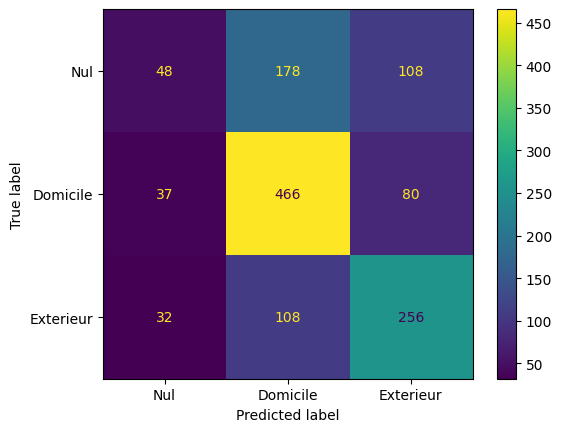

In [21]:
accuracy_result = accuracy_score(y_test_score, y_predictions)
#print(f'Threshold: {i} -> Accuracy: {accuracy_result}')
    
cm = confusion_matrix(y_test_score, y_predictions)
ConfusionMatrixDisplay(cm, display_labels=['Nul', 'Domicile', 'Exterieur']).plot()

In [24]:
print(classification_report(y_test_score, y_predictions))

              precision    recall  f1-score   support

           0       0.41      0.14      0.21       334
           1       0.62      0.80      0.70       583
           2       0.58      0.65      0.61       396

    accuracy                           0.59      1313
   macro avg       0.54      0.53      0.51      1313
weighted avg       0.55      0.59      0.55      1313



In [76]:
output_file_home = f'../model/model_result_home.bin'
output_file_away = f'../model/model_result_away.bin'

f_out_home = open(output_file_home, 'wb')
f_out_away = open(output_file_away, 'wb')

pickle.dump((dict_home, home_or_draw_model), f_out_home)
pickle.dump((dict_away, away_or_draw_model), f_out_away)

f_out_home.close()
f_out_away.close()